<a href="https://colab.research.google.com/github/julwdo/NLP-project/blob/main/NLP_Project_JW_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install -q sentence-transformers

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option("display.float_format", "{:.6f}".format)

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pyarrow.parquet as pq

path = "/content/drive/MyDrive/TwiBot-22_Processed"

enriched_user_features = pd.read_parquet(f"{path}/enriched_user_features.parquet", engine='pyarrow')

In [5]:
n_rows, n_columns = enriched_user_features.shape
print(f"The dataset contains {n_rows} rows and {n_columns} columns.")

The dataset contains 314813 rows and 58 columns.


In [6]:
enriched_user_features.head(2)

,id,name_length,username_length,username_name_length_ratio,description,description_length,has_name,has_username,has_description,has_url,has_location,has_pinned_tweet,has_bot_word_in_name,has_bot_word_in_description,ratio_digits_in_name,ratio_digits_in_username,ratio_digits_in_description,ratio_special_chars_in_name,ratio_special_chars_in_username,ratio_special_chars_in_description,name_upper_to_lower_ratio,username_upper_to_lower_ratio,name_entropy,username_entropy,username_name_levenshtein,description_sentiment,cashtag_in_description_count,hashtag_in_description_count,mention_in_description_count,url_in_description_count,is_protected,is_verified,account_age_seconds,followers_count,following_count,listed_count,tweet_count,followers_over_following,double_followers_over_following,following_over_followers,following_over_followers_squared,following_over_total_connections,listed_over_followers,tweets_over_followers,listed_over_tweets,follower_rate,following_rate,listed_rate,tweet_rate,label,top_tweets_concatenated_text,top_tweets_reply_fraction,top_tweets_num_distinct_langs,top_tweets_sensitive_fraction,top_tweets_avg_likes,top_tweets_avg_quotes,top_tweets_avg_replies,top_tweets_avg_retweets
0,u1001875491043889152,14,14,1.000000,VP Ops at Stealth Biotech | Former Site Direct...,159,True,True,True,False,True,True,False,False,0.000000,0.000000,0.018868,0.000000,0.071429,0.069182,0.181818,0.000000,2.950212,2.950212,0.857143,-0.077200,0,0,4,0,False,False,231101751,3555,2707,15,685,1.313262,2.626524,0.761463,0.000214,0.432290,0.004219,0.192686,0.021898,0.000015,0.000012,0.000000,0.000003,human,Great thread on building your startup. 40+ les...,0.300000,1,0.000000,0.700000,0.000000,0.000000,38.900000
1,u1002493985867423744,20,12,0.600000,French ambassador in Kenya and Somalia,38,True,True,True,False,True,False,False,False,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.214286,0.200000,3.884184,3.022055,0.450000,0.000000,0,0,0,0,False,False,230954290,1899,93,13,785,20.419355,40.838710,0.048973,0.000026,0.046687,0.006846,0.413375,0.016561,0.000008,0.000000,0.000000,0.000003,human,"RT <USER>: ""I spoke to President Putin this mo...",0.000000,1,0.000000,1.300000,NaN,NaN,14.000000


In [7]:
# Check for missing values
if enriched_user_features.isnull().any().any():
    print("Missing values found in the dataset.")
    na_summary = enriched_user_features.isnull().sum().loc[lambda x: x > 0].to_frame(name='Missing Count')
    na_summary['Missing Percentage'] = (na_summary['Missing Count'] / enriched_user_features.shape[0]) * 100
    print("\nSummary of missing values:")
    print(na_summary)
else:
    print("No missing values found in the dataset.")

Missing values found in the dataset.

Summary of missing values:
                        Missing Count  Missing Percentage
top_tweets_avg_quotes          177933           56.520220
top_tweets_avg_replies         177933           56.520220


In [9]:
enriched_user_features.dropna(axis=1, inplace=True)  # drop columns with any NaNs

In [10]:
# Check for missing values again
if enriched_user_features.isnull().any().any():
    print("Missing values found in the dataset.")
    na_summary = enriched_user_features.isnull().sum().loc[lambda x: x > 0].to_frame(name='Missing Count')
    na_summary['Missing Percentage'] = (na_summary['Missing Count'] / enriched_user_features.shape[0]) * 100
    print("\nSummary of missing values:")
    print(na_summary)
else:
    print("No missing values found in the dataset.")

No missing values found in the dataset.


In [11]:
# Check and handle duplicate rows
duplicates = enriched_user_features.duplicated().sum()
if duplicates > 0:
    print(f"Warning: The dataset contains {duplicates} duplicate rows.")
    enriched_user_features = enriched_user_features.drop_duplicates()
    print(f"\n{duplicates} duplicate rows have been dropped. The dataset now has {enriched_user_features.shape[0]} rows.")
else:
    print("No duplicate rows found in the dataset.")

No duplicate rows found in the dataset.


In [12]:
# Cast label column: 1 if "bot", 0 if "human"
enriched_user_features['label'] = enriched_user_features['label'].map({'human': 0, 'bot': 1})

In [13]:
enriched_user_features.head(2)

,id,name_length,username_length,username_name_length_ratio,description,description_length,has_name,has_username,has_description,has_url,has_location,has_pinned_tweet,has_bot_word_in_name,has_bot_word_in_description,ratio_digits_in_name,ratio_digits_in_username,ratio_digits_in_description,ratio_special_chars_in_name,ratio_special_chars_in_username,ratio_special_chars_in_description,name_upper_to_lower_ratio,username_upper_to_lower_ratio,name_entropy,username_entropy,username_name_levenshtein,description_sentiment,cashtag_in_description_count,hashtag_in_description_count,mention_in_description_count,url_in_description_count,is_protected,is_verified,account_age_seconds,followers_count,following_count,listed_count,tweet_count,followers_over_following,double_followers_over_following,following_over_followers,following_over_followers_squared,following_over_total_connections,listed_over_followers,tweets_over_followers,listed_over_tweets,follower_rate,following_rate,listed_rate,tweet_rate,label,top_tweets_concatenated_text,top_tweets_reply_fraction,top_tweets_num_distinct_langs,top_tweets_sensitive_fraction,top_tweets_avg_likes,top_tweets_avg_retweets
0,u1001875491043889152,14,14,1.000000,VP Ops at Stealth Biotech | Former Site Direct...,159,True,True,True,False,True,True,False,False,0.000000,0.000000,0.018868,0.000000,0.071429,0.069182,0.181818,0.000000,2.950212,2.950212,0.857143,-0.077200,0,0,4,0,False,False,231101751,3555,2707,15,685,1.313262,2.626524,0.761463,0.000214,0.432290,0.004219,0.192686,0.021898,0.000015,0.000012,0.000000,0.000003,0,Great thread on building your startup. 40+ les...,0.300000,1,0.000000,0.700000,38.900000
1,u1002493985867423744,20,12,0.600000,French ambassador in Kenya and Somalia,38,True,True,True,False,True,False,False,False,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.214286,0.200000,3.884184,3.022055,0.450000,0.000000,0,0,0,0,False,False,230954290,1899,93,13,785,20.419355,40.838710,0.048973,0.000026,0.046687,0.006846,0.413375,0.016561,0.000008,0.000000,0.000000,0.000003,0,"RT <USER>: ""I spoke to President Putin this mo...",0.000000,1,0.000000,1.300000,14.000000


In [14]:
# Count human and bot accounts
human_count = (enriched_user_features['label'] == 0).sum()
bot_count = n_rows - human_count

human_pct = human_count / n_rows * 100
bot_pct = bot_count / n_rows * 100

print(f"Number of human accounts: {human_count} ({human_pct:.2f}%)")
print(f"Number of bot accounts: {bot_count} ({bot_pct:.2f}%)")

Number of human accounts: 291089 (92.46%)
Number of bot accounts: 23724 (7.54%)


In [15]:
# Separate features (X) and target (y)
X = enriched_user_features.drop(columns=['id', 'label'])
y = enriched_user_features['label']

In [16]:
X.dtypes.unique()

array([dtype('int32'), dtype('float64'), dtype('O'), dtype('bool'),
       dtype('float32'), dtype('int64')], dtype=object)

In [17]:
n_features = X.shape[1]

numeric_cols = X.select_dtypes(include=['int32', 'float64', 'float32', 'int64']).columns
bool_cols = X.select_dtypes(include=['bool']).columns
text_cols = X.select_dtypes(include=['O']).columns

numeric_bool_cols = numeric_cols.append(bool_cols)

print(f"There are {n_features} features: {len(numeric_cols)} numeric, {len(bool_cols)} boolean, {len(text_cols)} text/object.")

There are 54 features: 42 numeric, 10 boolean, 2 text/object.


In [18]:
from sklearn.model_selection import train_test_split

# Train, test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
    )

In [19]:
def report_split(y, split_name):
    n = len(y)
    pct = n / len(enriched_user_features) * 100
    class_counts = y.value_counts()
    class_pct = y.value_counts(normalize=True) * 100

    print(f"{split_name} set: {n} rows ({pct:.2f}% of dataset)")
    for cls in class_counts.index:
        print(f"  Class {cls}: {class_counts[cls]} rows ({class_pct[cls]:.2f}%)")
    print("-" * 40)

report_split(y_train, "Training")
report_split(y_test, "Test")

Training set: 283331 rows (90.00% of dataset)
  Class 0: 261979 rows (92.46%)
  Class 1: 21352 rows (7.54%)
----------------------------------------
Test set: 31482 rows (10.00% of dataset)
  Class 0: 29110 rows (92.47%)
  Class 1: 2372 rows (7.53%)
----------------------------------------


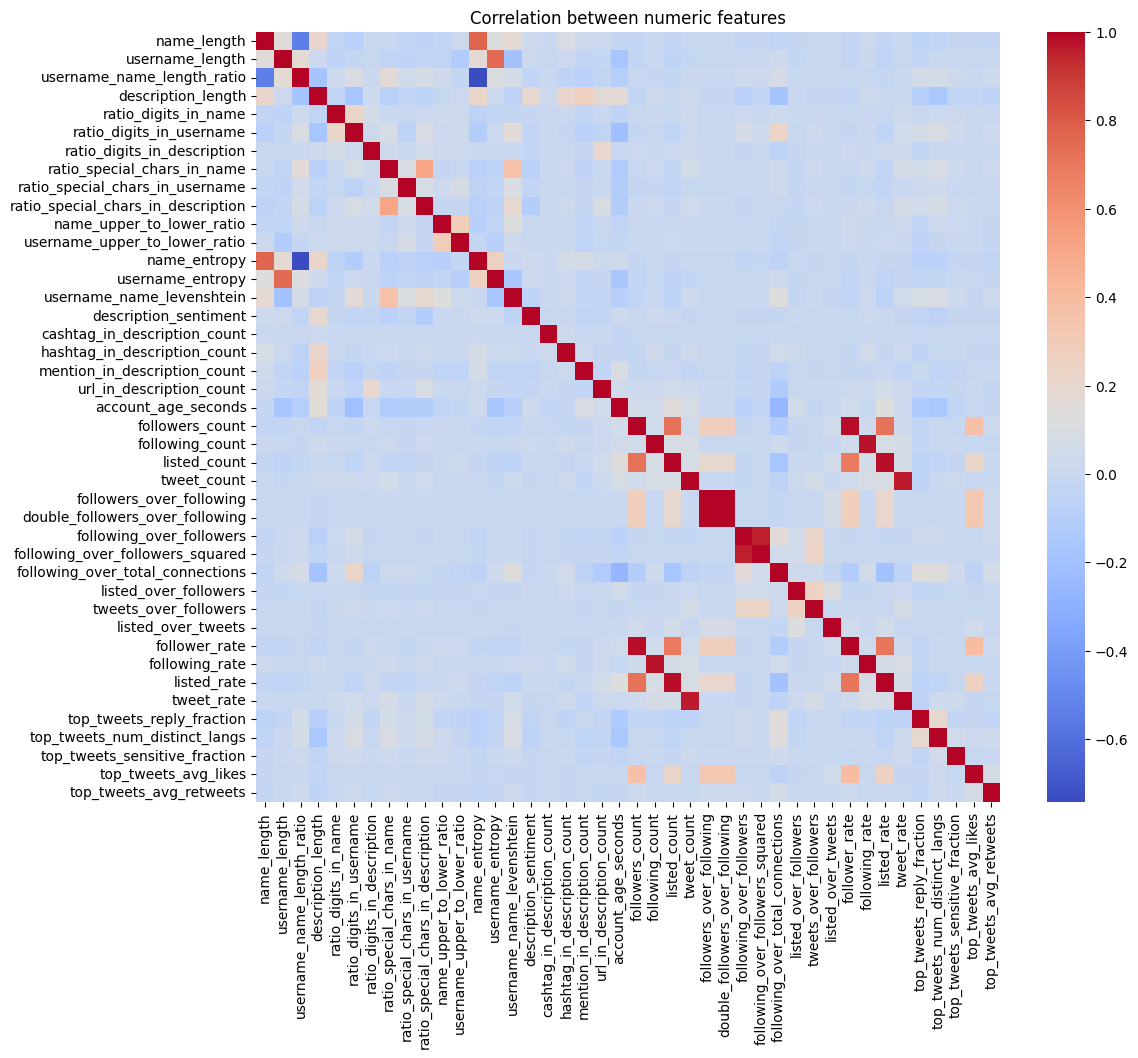

In [20]:
# Check pairwise correlations between numeric features
corr_matrix = X_train[numeric_cols].corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm')
plt.title("Correlation between numeric features")
plt.show()

In [21]:
from itertools import combinations

threshold = 0.8
high_corr = []

for col1, col2 in combinations(numeric_cols, 2):
    corr_val = corr_matrix.loc[col1, col2]
    if abs(corr_val) > threshold:
        high_corr.append((col1, col2, corr_val))

print("Highly correlated pairs (>|0.8|):")
for col1, col2, corr_val in high_corr:
    print(f"{col1} - {col2}: {corr_val:.2f}")

Highly correlated pairs (>|0.8|):
followers_count - follower_rate: 0.98
following_count - following_rate: 0.98
listed_count - listed_rate: 0.99
tweet_count - tweet_rate: 0.96
followers_over_following - double_followers_over_following: 1.00
following_over_followers - following_over_followers_squared: 0.96


In [22]:
# Check for numeric/boolean features with low variance
variances = X_train[numeric_bool_cols].var()

low_variance = variances[variances < 0.01].sort_values()

print("Features with variance < 0.01:")
for feature, var in low_variance.items():
    print(f"{feature}: {var:.6f}")

Features with variance < 0.01:
has_username: 0.000000
listed_rate: 0.000000
following_rate: 0.000000
tweet_rate: 0.000000
follower_rate: 0.000004
has_name: 0.000032
ratio_digits_in_description: 0.000829
has_bot_word_in_name: 0.000924
ratio_digits_in_name: 0.001506
has_bot_word_in_description: 0.001853
is_protected: 0.001994
ratio_special_chars_in_username: 0.002008
top_tweets_sensitive_fraction: 0.004211


In [23]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [24]:
'''
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class RoBERTaEmbedder(BaseEstimator, TransformerMixin):
    def __init__(self, model_name="sentence-transformers/distiluse-base-multilingual-cased-v1"):
      self.model_name = model_name
      self.model = SentenceTransformer(self.model_name)

    def fit(self, X, y=None):
      return self

    def transform(self, X):
      if isinstance(X, pd.DataFrame):
        X = X.values

      n_samples, n_cols = X.shape
      out = np.empty((n_samples, n_cols), dtype=object)

      for col_idx in range(n_cols):
        texts = X[:, col_idx]
        embeddings = self.model.encode(
            texts,
            batch_size=1024,
            show_progress_bar=True,
            device=device
            )  # (n_samples, embedding_dim)

        out[:, col_idx] = list(embeddings)

      return out
'''

In [27]:
'''
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_bool_pipeline = Pipeline([
    ("var_thresh", VarianceThreshold(threshold=0.01)),  # remove features with variance < 0.01
    ("model_sel", SelectFromModel(
        GradientBoostingClassifier(n_estimators=100, random_state=42),
        threshold="median"  # keep features above median importance
    ))
])

preprocessor = ColumnTransformer([
    ("numeric_bool_pipeline", numeric_bool_pipeline, numeric_bool_cols),
    ("text_embedding", RoBERTaEmbedder(), text_cols)
    ], remainder="passthrough")

# Fit on training set
preprocessor.fit(X_train, y_train)

# Transform train/test sets
X_train_selected = preprocessor.transform(X_train)
X_test_selected = preprocessor.transform(X_test)
'''

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/31 [00:00<?, ?it/s]

In [28]:
'''
np.save(f"{path}/X_train_selected.npy", X_train_selected)
np.save(f"{path}/X_test_selected.npy", X_test_selected)
'''

In [29]:
'''
import joblib
joblib.dump(preprocessor, f"{path}/preprocessor.joblib")
'''

['/content/drive/MyDrive/TwiBot-22_Processed/preprocessor.joblib']

In [30]:
import numpy as np
X_train_selected = np.load(f"{path}/X_train_selected.npy", allow_pickle=True)
X_test_selected = np.load(f"{path}/X_test_selected.npy", allow_pickle=True)

In [31]:
import joblib
preprocessor = joblib.load(f"{path}/preprocessor.joblib")

In [32]:
numeric_bool_pipeline_fitted = preprocessor.named_transformers_['numeric_bool_pipeline']

var_mask = numeric_bool_pipeline_fitted.named_steps['var_thresh'].get_support()
cols_after_var = numeric_bool_cols[var_mask]

sfm = numeric_bool_pipeline_fitted.named_steps['model_sel']
model_mask = sfm.get_support()
numeric_bool_cols_selected = cols_after_var[model_mask]

passthrough_cols = [col for col in X_train.columns if col not in numeric_bool_cols]

all_selected_cols = list(numeric_bool_cols_selected) + passthrough_cols

X_train_selected_df = pd.DataFrame(X_train_selected, columns=all_selected_cols)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=all_selected_cols)

# Restore feature types
numeric_cols_selected = [col for col in numeric_bool_cols_selected if col in numeric_cols]
bool_cols_selected = [col for col in numeric_bool_cols_selected if col in bool_cols]

X_train_selected_df[numeric_cols_selected] = X_train_selected_df[numeric_cols_selected].astype(float)
X_test_selected_df[numeric_cols_selected] = X_test_selected_df[numeric_cols_selected].astype(float)

X_train_selected_df[bool_cols_selected] = X_train_selected_df[bool_cols_selected].astype(int)
X_test_selected_df[bool_cols_selected] = X_test_selected_df[bool_cols_selected].astype(int)

In [33]:
X_train.head(2)

,name_length,username_length,username_name_length_ratio,description,description_length,has_name,has_username,has_description,has_url,has_location,has_pinned_tweet,has_bot_word_in_name,has_bot_word_in_description,ratio_digits_in_name,ratio_digits_in_username,ratio_digits_in_description,ratio_special_chars_in_name,ratio_special_chars_in_username,ratio_special_chars_in_description,name_upper_to_lower_ratio,username_upper_to_lower_ratio,name_entropy,username_entropy,username_name_levenshtein,description_sentiment,cashtag_in_description_count,hashtag_in_description_count,mention_in_description_count,url_in_description_count,is_protected,is_verified,account_age_seconds,followers_count,following_count,listed_count,tweet_count,followers_over_following,double_followers_over_following,following_over_followers,following_over_followers_squared,following_over_total_connections,listed_over_followers,tweets_over_followers,listed_over_tweets,follower_rate,following_rate,listed_rate,tweet_rate,top_tweets_concatenated_text,top_tweets_reply_fraction,top_tweets_num_distinct_langs,top_tweets_sensitive_fraction,top_tweets_avg_likes,top_tweets_avg_retweets
165336,11,11,1.000000,,0,True,True,False,False,True,False,False,False,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.250000,0.250000,3.095795,3.095795,0.909091,0.000000,0,0,0,0,False,False,288822607,20,76,0,2,0.263158,0.526316,3.800000,0.190000,0.791667,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,<USER> <USER> Carpet mill East Ardsley I can h...,1.000000,1,0.000000,0.000000,0.000000
154804,15,11,0.733333,"Fintech, crypto, NFT. Founder <USER> <USER>. A...",156,True,True,True,True,True,False,False,False,0.000000,0.000000,0.000000,0.066667,0.000000,0.102564,0.181818,0.000000,3.189898,3.095795,0.933333,0.000000,0,0,5,0,False,False,487716815,5664,556,486,13613,10.187050,20.374101,0.098164,0.000017,0.089389,0.085805,2.403425,0.035701,0.000012,0.000001,0.000001,0.000028,I'm doing my DYOR on $LUNA and it seems that i...,0.000000,1,0.000000,0.000000,2335.666667


In [34]:
X_train_selected_df.head(2)

,name_length,username_name_length_ratio,description_length,ratio_special_chars_in_name,ratio_special_chars_in_description,hashtag_in_description_count,mention_in_description_count,account_age_seconds,followers_count,following_count,tweet_count,following_over_followers,listed_over_followers,tweets_over_followers,listed_over_tweets,top_tweets_num_distinct_langs,top_tweets_avg_likes,top_tweets_avg_retweets,has_description,is_verified,description,top_tweets_concatenated_text
0,11.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,288822607.000000,20.000000,76.000000,2.000000,3.800000,0.000000,0.100000,0.000000,1.000000,0.000000,0.000000,0,0,"[0.014341043, -0.027605772, -0.032804664, -0.0...","[0.06489195, -0.03907821, 0.039468978, -0.0560..."
1,15.000000,0.733333,156.000000,0.066667,0.102564,0.000000,5.000000,487716815.000000,5664.000000,556.000000,13613.000000,0.098164,0.085805,2.403425,0.035701,1.000000,0.000000,2335.666667,1,0,"[-0.035987668, 0.011791925, 0.049600534, -0.02...","[-0.0020513302, 0.019294605, -0.012940815, -0...."


In [35]:
X_train_selected_df.dtypes

,0
name_length,float64
username_name_length_ratio,float64
description_length,float64
ratio_special_chars_in_name,float64
ratio_special_chars_in_description,float64
hashtag_in_description_count,float64
mention_in_description_count,float64
account_age_seconds,float64
followers_count,float64
following_count,float64


In [36]:
print("Selected numeric/boolean features:")
print(list(numeric_bool_cols_selected))

Selected numeric/boolean features:
['name_length', 'username_name_length_ratio', 'description_length', 'ratio_special_chars_in_name', 'ratio_special_chars_in_description', 'hashtag_in_description_count', 'mention_in_description_count', 'account_age_seconds', 'followers_count', 'following_count', 'tweet_count', 'following_over_followers', 'listed_over_followers', 'tweets_over_followers', 'listed_over_tweets', 'top_tweets_num_distinct_langs', 'top_tweets_avg_likes', 'top_tweets_avg_retweets', 'has_description', 'is_verified']


In [37]:
# Check feature importances
importances = sfm.estimator_.feature_importances_[model_mask]

feat_importances = pd.DataFrame({
    "feature": numeric_bool_cols_selected,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(feat_importances)

                               feature  importance
8                      followers_count    0.499868
2                   description_length    0.110718
10                         tweet_count    0.109413
18                     has_description    0.093354
9                      following_count    0.062435
17             top_tweets_avg_retweets    0.025300
19                         is_verified    0.021786
7                  account_age_seconds    0.016460
1           username_name_length_ratio    0.009408
4   ratio_special_chars_in_description    0.008724
3          ratio_special_chars_in_name    0.007130
5         hashtag_in_description_count    0.005608
12               listed_over_followers    0.004266
14                  listed_over_tweets    0.003936
0                          name_length    0.003742
15       top_tweets_num_distinct_langs    0.003185
16                top_tweets_avg_likes    0.002327
6         mention_in_description_count    0.001639
13               tweets_over_fo

In [40]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit on training set
scaler.fit(X_train_selected_df[numeric_cols_selected])

# Transform train/test sets
X_train_scaled = X_train_selected_df.copy()
X_test_scaled = X_test_selected_df.copy()

X_train_scaled[numeric_cols_selected] = scaler.transform(X_train_selected_df[numeric_cols_selected])
X_test_scaled[numeric_cols_selected] = scaler.transform(X_test_selected_df[numeric_cols_selected])

In [41]:
X_train_scaled.head(2)

,name_length,username_name_length_ratio,description_length,ratio_special_chars_in_name,ratio_special_chars_in_description,hashtag_in_description_count,mention_in_description_count,account_age_seconds,followers_count,following_count,tweet_count,following_over_followers,listed_over_followers,tweets_over_followers,listed_over_tweets,top_tweets_num_distinct_langs,top_tweets_avg_likes,top_tweets_avg_retweets,has_description,is_verified,description,top_tweets_concatenated_text
0,-0.502771,0.064187,-2.085108,-0.381874,-0.650481,-0.363490,-0.489250,-0.699049,-0.090620,-0.145197,-0.237651,0.091031,-0.172577,-0.030524,-0.022254,-0.695240,-0.047600,-0.124132,0,0,"[0.014341043, -0.027605772, -0.032804664, -0.0...","[0.06489195, -0.03907821, 0.039468978, -0.0560..."
1,0.030390,-0.287965,1.009373,-0.023766,0.019873,-0.363490,3.660570,0.795050,-0.084637,-0.121590,-0.136391,-0.087700,0.410938,-0.026806,-0.015071,-0.695240,-0.047600,0.372063,1,0,"[-0.035987668, 0.011791925, 0.049600534, -0.02...","[-0.0020513302, 0.019294605, -0.012940815, -0...."


In [45]:
X_train_numeric_bool = X_train_scaled[numeric_bool_cols_selected].astype(np.float32).to_numpy()
X_train_text = np.hstack([np.stack(X_train_scaled[col].values) for col in text_cols])
X_train_embedded = np.hstack([X_train_numeric_bool, X_train_text])

X_test_numeric_bool = X_test_scaled[numeric_bool_cols_selected].astype(np.float32).to_numpy()
X_test_text = np.hstack([np.stack(X_test_scaled[col].values) for col in text_cols])
X_test_embedded = np.hstack([X_test_numeric_bool, X_test_text])

In [46]:
X_train_embedded.shape  # 18 numeric, 2 bool, 512 embeddings for each of the 2 text features

(283331, 1044)

In [47]:
y_train_embedded = y_train.to_numpy().astype(np.float32)
y_test_embedded = y_test.to_numpy().astype(np.float32)

In [48]:
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.from_numpy(X_train_embedded)
X_test_tensor = torch.from_numpy(X_test_embedded)

y_train_tensor = torch.from_numpy(y_train_embedded).unsqueeze(1)
y_test_tensor = torch.from_numpy(y_test_embedded).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [49]:
import torch.nn as nn

class SimpleMLP(nn.Module):
    def __init__(self, input_dim):
        super(SimpleMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [50]:
pos_weight = y_train_tensor.shape[0] / (y_train_tensor[y_train_tensor == 1].shape[0] * 2)
pos_weight

6.634764893218434

In [51]:
input_dim = X_train_tensor.shape[1]

model = SimpleMLP(input_dim)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
  for xb, yb in train_loader:
    optimizer.zero_grad()
    preds = model(xb)
    loss = criterion(preds, yb)
    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 1.9951
Epoch 2, Loss: 1.0699
Epoch 3, Loss: 0.6932
Epoch 4, Loss: 0.6931
Epoch 5, Loss: 1.1550
Epoch 6, Loss: 0.6931
Epoch 7, Loss: 0.6931
Epoch 8, Loss: 0.6933
Epoch 9, Loss: 0.6931
Epoch 10, Loss: 0.7341


In [52]:
import torch.nn.functional as F

model.eval()
y_preds = []
y_true_labels = []

with torch.no_grad():
  for xb, yb in test_loader:
    preds = model(xb)
    y_preds.append(preds)
    y_true_labels.append(yb)

y_preds = torch.cat(y_preds, dim=0).numpy()
y_true_labels = torch.cat(y_true_labels, dim=0).numpy()

y_pred_labels = (y_preds >= 0.5).astype(int)  # threshold at 0.5

In [53]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

acc = accuracy_score(y_true_labels, y_pred_labels)
f1 = f1_score(y_true_labels, y_pred_labels)
auc = roc_auc_score(y_true_labels, y_preds)  # use probabilities
cm = confusion_matrix(y_true_labels, y_pred_labels)

print(f"Accuracy: {acc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print("Confusion Matrix:")
print(cm)

Accuracy: 0.9083
F1-score: 0.4274
AUC: 0.8324
Confusion Matrix:
[[27516  1594]
 [ 1294  1078]]
